In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc, col, count, avg, year, to_date, upper

# Crear sesión de Spark con soporte para Hive
spark = SparkSession.builder \
    .appName("Test Hive Connection") \
    .config("hive.metastore.uris", "thrift://172.17.0.2:9083") \
    .enableHiveSupport() \
    .getOrCreate()

def test_conection():
    try:
        spark.sql("SHOW DATABASES").show()
        print("Conexión exitosa a Hive")
    except Exception as e:
        print("Error en la conexión a Hive:", e)

test_conection()

+-------------+
|    namespace|
+-------------+
|   aviaciondb|
|car_rental_db|
|      default|
|     tripdata|
+-------------+

Conexión exitosa a Hive


In [3]:
df = spark.sql("SELECT * FROM aviaciondb.aeropuerto_detalles_tabla_transform")

### 6 -  Determinar la cantidad de vuelos entre las fechas 01/12/2021 y 31/01/2022. Mostrar consulta y Resultado de la query

In [5]:
# Filtrar y contar los vuelos
df_filtered = df.filter((col('fecha') >= '2021-12-01') & (col('fecha') <= '2022-01-31'))
cantidad_vuelos = df_filtered.count()
print("Cantidad de vuelos en diciembre 2021 y enero 2022:", cantidad_vuelos)

Cantidad de vuelos en diciembre 2021 y enero 2022: 3040848


### 7 - Cantidad de pasajeros que viajaron en Aerolíneas Argentinas entre el 01/01/2021 y 30/06/2022. Mostrar consulta y Resultado de la query

In [10]:
df_filtered = df.filter((col('fecha') >= '2021-01-01') & (col('fecha') <= '2022-06-30') & (upper(col('aerolinea_nombre')).contains('AEROLINEAS ARGENTINAS')))
cantidad_pasajeros = df_filtered.groupBy().sum('pasajeros').collect()[0][0]
print("Cantidad de pasajeros de Aerolíneas Argentinas en el primer semestre de 2021:", cantidad_pasajeros)

Cantidad de pasajeros de Aerolíneas Argentinas en el primer semestre de 2021: 50620496


### 8 - Mostrar fecha, hora, código aeropuerto salida, ciudad de salida, código de aeropuerto de arribo, ciudad de arribo, y cantidad de pasajeros de cada vuelo, entre el 01/01/2022 y el 30/06/2022 ordenados por fecha de manera descendiente. Mostrar consulta y Resultado de la query

In [12]:
# Filtrar y seleccionar columnas específicas
# Filtrar los vuelos entre las fechas especificadas y que sean despegues
df_filtered_salida = df.filter(
    (col('fecha') >= '2022-01-01') & 
    (col('fecha') <= '2022-06-30') & 
    (col('tipo_de_movimiento') == 'Despegue')
)

# Seleccionar las columnas necesarias
df_selected_salida = df_filtered_salida.select(
    col('fecha'),
    col('horautc').alias('hora'),
    col('aeropuerto').alias('codigo_aeropuerto_salida'),
    col('origen_destino').alias('ciudad_salida'),
    col('pasajeros')
)

# Filtrar los vuelos que son arribos entre las fechas especificadas y que sean aterrizajes
df_filtered_llegada = df.filter(
    (col('fecha') >= '2022-01-01') & 
    (col('fecha') <= '2022-06-30') & 
    (col('tipo_de_movimiento') == 'Aterrizaje')
)

# Seleccionar las columnas necesarias
df_selected_llegada = df_filtered_llegada.select(
    col('fecha'),
    col('horautc').alias('hora'),
    col('aeropuerto').alias('codigo_aeropuerto_arrivo'),
    col('origen_destino').alias('ciudad_arrivo'),
    col('pasajeros')
)

# Mostrar el resultado ordenado por fecha de manera descendente
df_union = df_selected_salida.unionByName(df_selected_llegada, allowMissingColumns=True)
df_result = df_union.orderBy(col('fecha').desc())
df_result.show(10)

+----------+-----+------------------------+-------------+---------+------------------------+-------------+
|     fecha| hora|codigo_aeropuerto_salida|ciudad_salida|pasajeros|codigo_aeropuerto_arrivo|ciudad_arrivo|
+----------+-----+------------------------+-------------+---------+------------------------+-------------+
|2022-01-31|00:04|                     IGU|          EZE|        0|                    NULL|         NULL|
|2022-01-31|00:03|                    NULL|         NULL|       88|                     AER|          BAR|
|2022-01-31|00:03|                    NULL|         NULL|       88|                     AER|          BAR|
|2022-01-31|00:36|                    NULL|         NULL|       50|                     AER|          ROS|
|2022-01-31|00:04|                    NULL|         NULL|        0|                     EZE|          DOZ|
|2022-01-31|00:09|                    NULL|         NULL|       43|                     AER|          GAL|
|2022-01-31|00:36|                   

### 10 - Cuales son las 10 aerolíneas que más pasajeros llevaron entre el 01/01/2021 y el 30/06/2022 exceptuando aquellas aerolíneas que no tengan nombre. Mostrar consulta y Visualización

In [16]:
# Filtrar los datos, agrupar por aerolínea y sumar los pasajeros
df_filtered = df.filter((col('fecha') >= '2021-01-01') & (col('fecha') <= '2022-06-30') & (col('aerolinea_nombre').isNotNull()))
df_result = df_filtered.groupBy('aerolinea_nombre').sum('pasajeros').orderBy(desc('sum(pasajeros)')).limit(10)

df_result.show(5)

+--------------------+--------------+
|    aerolinea_nombre|sum(pasajeros)|
+--------------------+--------------+
|AEROLINEAS ARGENT...|      50620496|
|JETSMART AIRLINES...|      10564208|
|FB LÍNEAS AÉREAS ...|       9727824|
|                   0|        424592|
|   AMERICAN JET S.A.|        130832|
+--------------------+--------------+
only showing top 5 rows



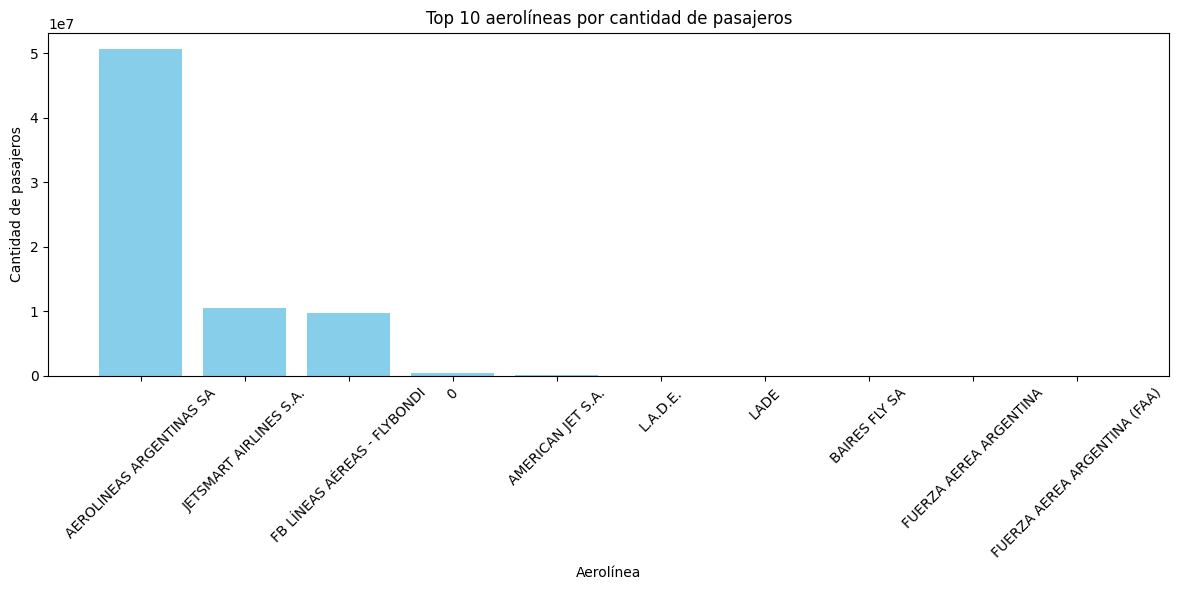

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Convertir los resultados a un DataFrame de Pandas
df_pandas = df_result.toPandas()

# Crear la visualización
plt.figure(figsize=(12, 6))
plt.bar(df_pandas['aerolinea_nombre'], df_pandas['sum(pasajeros)'], color='skyblue')
plt.xlabel('Aerolínea')
plt.ylabel('Cantidad de pasajeros')
plt.title('Top 10 aerolíneas por cantidad de pasajeros')
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar la visualización
plt.show()


### 10 - Cuales son las 10 aeronaves más utilizadas entre el 01/01/2021 y el 30/06/22 que despegaron desde la Ciudad autónoma de Buenos Aires o de Buenos Aires, exceptuando aquellas aeronaves que no cuentan con nombre. Mostrar consulta y Visualización

In [21]:
# Filtrar los datos, agrupar por aeronave y contar los vuelos
df_filtered = df.filter((col('fecha') >= '2021-01-01') & (col('fecha') <= '2022-06-30') & (upper(col('origen_destino')).contains('AEP') | upper(col('origen_destino')).contains('EZE') ) & (col('aeronave').isNotNull()))
df_result = df_filtered.groupBy('aeronave').count().orderBy(desc('count')).limit(10)

df_result.show(10)

+----------------+-----+
|        aeronave|count|
+----------------+-----+
|EMB-ERJ190100IGW|10080|
|      BO-737-800| 9440|
|     BO-B737-800| 7056|
|    AIB-A330-202| 6144|
|    AIB-A320-232| 5856|
|    BO-B-737-76N| 5520|
|      BO-737-8SH| 5024|
|      BO-737-8HX| 3872|
|      BO-737-8Q8| 3728|
|    AIB-A330-203| 3712|
+----------------+-----+



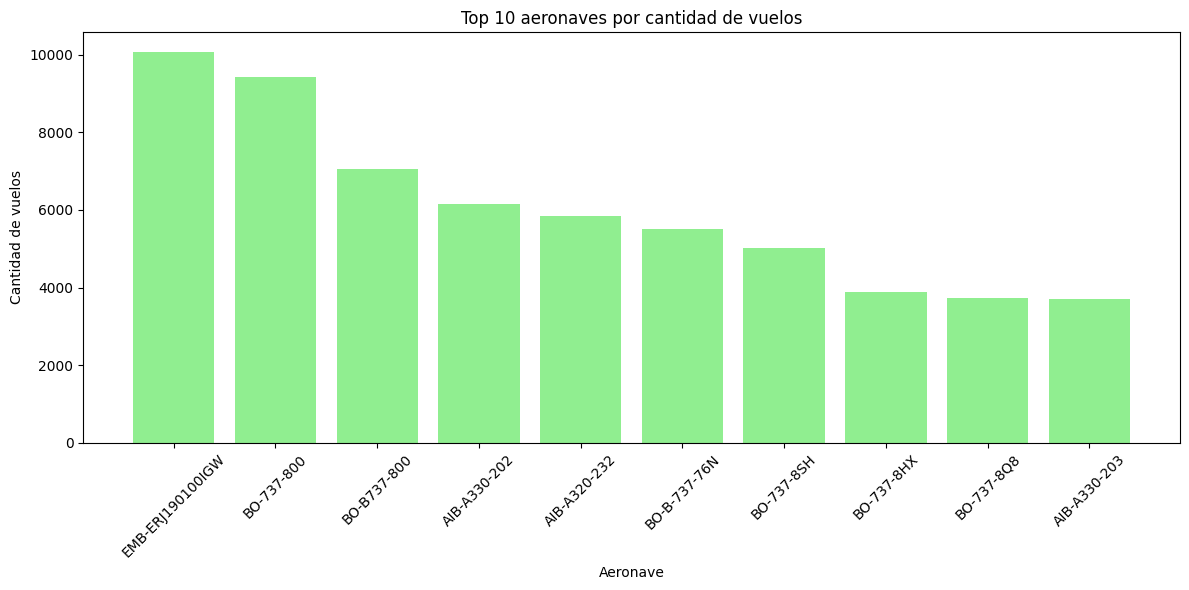

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Convertir los resultados a un DataFrame de Pandas
df_pandas = df_result.toPandas()

# Crear la visualización
plt.figure(figsize=(12, 6))
plt.bar(df_pandas['aeronave'], df_pandas['count'], color='lightgreen')
plt.xlabel('Aeronave')
plt.ylabel('Cantidad de vuelos')
plt.title('Top 10 aeronaves por cantidad de vuelos')
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar la visualización
plt.show()
